1. j = the highest pt anti-kt jet (R=1)
2. run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
3. phi = sj1.phi(); for all c, do c.rotate_z(-phi)
4. bv = sj1.boost_vector(); bv.set_perp(0); for all c, do c.boost(-bv)
5. deltaz = sj1.pz - sj2.pz; deltay = sj1.py - sj2.py; alpha = -atan2(deltaz, deltay); for all c, do c.rotate_x(alpha)
6. if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
7. finally recluster all transformed constituents c into a single jet (using kt or anti-kt? r?)

In [1]:
%load_ext cython
import pickle
import numpy as np

In [2]:
%%cython -f -+ -I/home/gilles/anaconda3/envs/hep/include --link-args=-Wl,-rpath,/home/gilles/anaconda3/envs/hep/lib  -lm -L/home/gilles/anaconda3/envs/hep/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/gilles/gdrive/research/sandbox/learning-qcd-rnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=0.3, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array([e for e in tree]).reshape(-1, 2)
        content = np.array([e for e in content]).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

In [64]:
import copy
from rootpy.vector import LorentzVector

def preprocess(jet):
    jet = copy.deepcopy(jet)
    constituents = jet["content"][jet["tree"][:, 0] == -1] 

    # run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
    subjets = cluster(constituents, R=0.3, jet_algorithm=0)
    
    # phi = sj1.phi()
    # for all c, do c.rotate_z(-phi)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    phi = v.phi()
    
    for _, content, _, _ in subjets:
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.rotate_z(-phi)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
            
    # bv = sj1.boost_vector()
    # bv.set_perp(0)
    # for all c, do c.boost(-bv)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    bv = v.boost_vector()
    bv.set_perp(0)
    
    for _, content, _, _ in subjets:        
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.boost(-bv)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
    
    # deltaz = sj1.pz - sj2.pz
    # deltay = sj1.py - sj2.py
    # alpha = -atan2(deltaz, deltay)
    # for all c, do c.rotate_x(alpha)
    if len(subjets) >= 2:
        deltaz = subjets[0][1][0, 2] - subjets[1][1][0, 2]
        deltay = subjets[0][1][0, 1] - subjets[1][1][0, 1]
        alpha = -np.arctan2(deltaz, deltay)

        for _, content, _, _ in subjets:
            for i in range(len(content)):
                v = LorentzVector(content[i])
                v.rotate_x(alpha)
                content[i, 0] = v[0]
                content[i, 1] = v[1]
                content[i, 2] = v[2]
                content[i, 3] = v[3]
    
    # if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
    if len(subjets) >= 3 and subjets[2][1][0, 2] < 0:
        for _, content, _, _ in subjets:
            for i in range(len(content)):
                content[i, 2] *= -1.0
                
    # finally recluster all transformed constituents c into a single jet 
    constituents = []
    
    for tree, content, _, _ in subjets:
        constituents.append(content[tree[:, 0] == -1])
        
    constituents = np.vstack(constituents)
    subjets = cluster(constituents, R=100., jet_algorithm=1)
    
    jet["tree"] = subjets[0][0]
    jet["content"] = subjets[0][1]
    
    v = LorentzVector(jet["content"][0])
    jet["phi"] = v.phi()
    jet["eta"] = v.eta()
    jet["energy"] = v.E()
    jet["mass"] = v.m()
    jet["pt"] = v.pt()
    jet["root_id"] = 0
    
    return jet

# Convert data

In [93]:
fd = open("../data/w-vs-qcd/antikt-train.pickle-py27", "rb")
X, y = pickle.load(fd)
fd.close()

X = [preprocess(j) for j in X]

fd = open("../data/w-vs-qcd/antikt-train-pp.pickle-py27", "wb")
pickle.dump((X, y), fd, protocol=2)
fd.close()

# Checks

In [65]:
fd = open("../data/w-vs-qcd/antikt-test.pickle-py27", "rb")
X, y = pickle.load(fd)
fd.close()

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
from rootpy.vector import LorentzVector

In [67]:
from matplotlib.colors import LogNorm
a = []

for j in X[10000:]:
    if 50 < j["mass"] < 110 and 200 < j["pt"] < 500:
        j = preprocess(j)
        constituents = j["content"][j["tree"][:, 0] == -1]
        a.append(np.array([[LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
    
a = np.vstack(a)

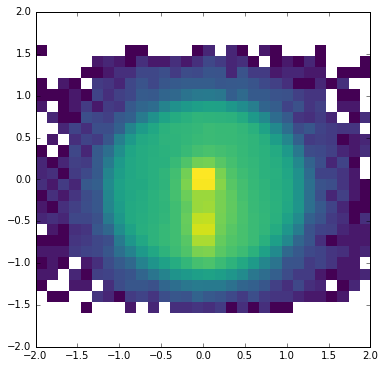

In [68]:
plt.hist2d(a[:, 0], a[:, 1], range=[(-2,2), (-2,2)], bins=30, cmap="viridis", norm=LogNorm())
plt.show()